In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import scipy
import numpy as np
import openpyxl


# 1. Load Raw Data
csv_raw = pd.read_csv("./data/data.csv", skiprows=1, parse_dates=['datetime'], dayfirst=False)

# 2. extract usable raw component(columns) ordered by datatime
raw_data = csv_raw[['datetime', 'warmup', 'off', 
                   'add_amount_brightener', 'add_amount_carrier', 
                   'velocity','tension','v','a','temperature',
                   'copper_sulfate_content', 'sulfuric_acid_content', 'chloride_content']].sort_values("datetime")

# 3. extracted column data
raw_warmup = raw_data[~raw_data["warmup"].isna()][["datetime", "warmup"]]
raw_off = raw_data[~raw_data["off"].isna()][["datetime", "off"]]
raw_brightener = (raw_data[~raw_data["add_amount_brightener"].isna()])[["datetime", "add_amount_brightener"]]
raw_carrier = (raw_data[~raw_data["add_amount_carrier"].isna()])[["datetime", "add_amount_carrier"]]
raw_velocity = (raw_data[~raw_data["velocity"].isna()])[["datetime", "velocity"]]
raw_tension = (raw_data[~raw_data["tension"].isna()])[["datetime", "tension"]]
raw_voltage = (raw_data[~raw_data["v"].isna()])[["datetime", "v"]]
raw_ampere = (raw_data[~raw_data["a"].isna()])[["datetime", "a"]]
raw_temperature = (raw_data[~raw_data["temperature"].isna()])[["datetime", "temperature"]]
raw_cs = (raw_data[~raw_data["copper_sulfate_content"].isna()])[["datetime", "copper_sulfate_content"]]
raw_sa = (raw_data[~raw_data["sulfuric_acid_content"].isna()])[["datetime", "sulfuric_acid_content"]]
raw_c = (raw_data[~raw_data["chloride_content"].isna()])[["datetime", "chloride_content"]]

#4. Create new data frame (for every single day operation)
raw_day = pd.DataFrame(dtype=float, columns=['datetime', 'optime', 'optime_min', 'add_amount_brightener', 'add_amount_carrier', 
                                             'velocity_mean', 'velocity_var', 'velocity_std',
                                             'tension_mean','tension_var', 'tension_std',
                                             'voltage_mean','voltage_var', 'voltage_std',
                                             'ampere_mean','ampere_var', 'ampere_std',
                                             'temperature_mean','temperature_var', 'temperature_std',
                                             'cs_mean','cs_var', 'cs_std',
                                             'sa_mean','sa_var', 'sa_std',
                                             'c_mean','c_var', 'c_std'])

#5. Calculate operation time (every single day)
for warmup, off in zip(raw_warmup.iterrows(), raw_off.iterrows()):
    value = [off[1]["datetime"], off[1]["datetime"]-warmup[1]["datetime"]]
    value.extend([np.nan for i in range(0, raw_day.shape[1]-len(value))])
    raw_day.loc[len(raw_day.index)] = value

raw_day = raw_day.groupby(pd.Grouper(key='datetime', freq='D', sort=True)).sum()
raw_day = raw_day[raw_day["optime"]!=datetime.timedelta(seconds=0)] # drop no timedelta
raw_day["optime_min"] = [i.total_seconds()/60 for i in raw_day.loc[:,"optime"]] # add time min
raw_day = raw_day.drop(columns="optime")


#6. update all data corresponding to optime date
for t_idx in raw_day.index:
    mask_brightener = list((raw_brightener["datetime"]>t_idx) & (raw_brightener["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_carrier = list((raw_carrier["datetime"]>t_idx) & (raw_carrier["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_voltage = list((raw_voltage["datetime"]>t_idx) & (raw_voltage["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_ampere = list((raw_ampere["datetime"]>t_idx) & (raw_ampere["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_temperature = list((raw_temperature["datetime"]>t_idx) & (raw_temperature["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_tension = list((raw_tension["datetime"]>t_idx) & (raw_tension["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_velocity = list((raw_velocity["datetime"]>t_idx) & (raw_velocity["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_cs = list((raw_cs["datetime"]>t_idx) & (raw_cs["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_sa = list((raw_sa["datetime"]>t_idx) & (raw_sa["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_c = list((raw_c["datetime"]>t_idx) & (raw_c["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    
    if any(mask_brightener):
        raw_day.loc[t_idx, "add_amount_brightener"] = raw_brightener.loc[mask_brightener, "add_amount_brightener"].values[0]
    if any(mask_carrier):
        raw_day.loc[t_idx, "add_amount_carrier"] = raw_carrier.loc[mask_carrier, "add_amount_carrier"].values[0]
    if any(mask_voltage):
        raw_day.loc[t_idx, "voltage_mean"] = raw_voltage.loc[mask_voltage, "v"].values.mean()
        raw_day.loc[t_idx, "voltage_var"] = raw_voltage.loc[mask_voltage, "v"].values.var()
        raw_day.loc[t_idx, "voltage_std"] = raw_voltage.loc[mask_voltage, "v"].values.std()
    if any(mask_ampere):
        raw_day.loc[t_idx, "ampere_mean"] = raw_ampere.loc[mask_voltage, "a"].values.mean()
        raw_day.loc[t_idx, "ampere_var"] = raw_ampere.loc[mask_voltage, "a"].values.var()
        raw_day.loc[t_idx, "ampere_std"] = raw_ampere.loc[mask_voltage, "a"].values.std()
    if any(mask_temperature):
        raw_day.loc[t_idx, "temperature_mean"] = raw_temperature.loc[mask_temperature, "temperature"].values.mean()
        raw_day.loc[t_idx, "temperature_var"] = raw_temperature.loc[mask_temperature, "temperature"].values.var()
        raw_day.loc[t_idx, "temperature_std"] = raw_temperature.loc[mask_temperature, "temperature"].values.std()
    if any(mask_cs):
        raw_day.loc[t_idx, "cs_mean"] = raw_cs.loc[mask_cs, "copper_sulfate_content"].values.mean()
        raw_day.loc[t_idx, "cs_var"] = raw_cs.loc[mask_cs, "copper_sulfate_content"].values.var()
        raw_day.loc[t_idx, "cs_std"] = raw_cs.loc[mask_cs, "copper_sulfate_content"].values.std()
    if any(mask_sa):
        raw_day.loc[t_idx, "sa_mean"] = raw_sa.loc[mask_sa, "sulfuric_acid_content"].values.mean()
        raw_day.loc[t_idx, "sa_var"] = raw_sa.loc[mask_sa, "sulfuric_acid_content"].values.var()
        raw_day.loc[t_idx, "sa_std"] = raw_sa.loc[mask_sa, "sulfuric_acid_content"].values.std()
    if any(mask_c):
        raw_day.loc[t_idx, "c_mean"] = raw_c.loc[mask_cs, "chloride_content"].values.mean()
        raw_day.loc[t_idx, "c_var"] = raw_c.loc[mask_cs, "chloride_content"].values.var()
        raw_day.loc[t_idx, "c_std"] = raw_c.loc[mask_cs, "chloride_content"].values.std()
    if any(mask_velocity):
        raw_day.loc[t_idx, "velocity_mean"] = raw_velocity.loc[mask_velocity, "velocity"].values.mean()
        raw_day.loc[t_idx, "velocity_var"] = raw_velocity.loc[mask_velocity, "velocity"].values.var()
        raw_day.loc[t_idx, "velocity_std"] = raw_velocity.loc[mask_velocity, "velocity"].values.std()
    if any(mask_tension):
        raw_day.loc[t_idx, "tension_mean"] = raw_tension.loc[mask_tension, "tension"].values.mean()
        raw_day.loc[t_idx, "tension_var"] = raw_tension.loc[mask_tension, "tension"].values.var()
        raw_day.loc[t_idx, "tension_std"] = raw_tension.loc[mask_tension, "tension"].values.std()
        
# 7. drop the row with nan value of add_amount_brightener
raw_prepared = raw_day.loc[raw_day["add_amount_brightener"]!=0.0]

# 7.1 save to csv file
raw_prepared.to_csv('./aggregate.csv', sep=',')
raw_prepared.head()

# 7.2 normalization
# normal_tension = (raw_prepared.loc[:,"tension_mean"] - raw_prepared.loc[:,"tension_mean"].min())/(raw_prepared.loc[:,"tension_mean"].max() - raw_prepared.loc[:,"tension_mean"].min())
# normal_velocity = (raw_prepared.loc[:,"velocity_mean"] - raw_prepared.loc[:,"velocity_mean"].min())/(raw_prepared.loc[:,"velocity_mean"].max() - raw_prepared.loc[:,"velocity_mean"].min())


# print(type(raw_prepared.loc[:,"tension_mean"]))
# plt.clf()
# plt.figure(figsize=(10,5))
# plt.plot(normal_tension, 'r-', label="tension")
# plt.plot(normal_velocity, 'b-', label="velocity")
# plt.ylabel('Scaled')
# plt.title('Normalized data', fontsize=15)
# plt.legend()
# plt.tight_layout()
# plt.show()



,optime_min,add_amount_brightener,add_amount_carrier,velocity_mean,velocity_var,velocity_std,tension_mean,tension_var,tension_std,voltage_mean,...,temperature_std,cs_mean,cs_var,cs_std,sa_mean,sa_var,sa_std,c_mean,c_var,c_std
datetime,,,,,,,,,,,,,,,,,,,,,
2023-07-18 00:00:00+00:00,315.0,320.0,200.0,0.060,4.814825e-35,6.938894e-18,2.733333,0.013333,0.115470,2.009091,...,0.446661,143.5,0.0,0.0,132.79,0.0,0.0,0.0,0.0,0.0
2023-07-19 00:00:00+00:00,345.0,450.0,150.0,0.057,2.100000e-05,4.582576e-03,2.960000,0.016400,0.128062,1.975000,...,0.124900,144.5,0.0,0.0,133.28,0.0,0.0,0.0,0.0,0.0
2023-07-20 00:00:00+00:00,345.0,230.0,150.0,0.384,9.447840e-01,9.720000e-01,3.150000,0.030500,0.174642,2.000000,...,0.168523,144.5,0.0,0.0,136.22,0.0,0.0,0.0,0.0,0.0
2023-07-24 00:00:00+00:00,185.0,300.0,150.0,0.058,1.600000e-05,4.000000e-03,3.060000,0.010400,0.101980,2.100000,...,0.299333,142.5,0.0,0.0,133.77,0.0,0.0,0.0,0.0,0.0
2023-07-25 00:00:00+00:00,340.0,380.0,170.0,0.060,1.818182e-05,4.264014e-03,3.345455,0.033388,0.182725,2.092308,...,0.492422,159.5,0.0,0.0,145.04,0.0,0.0,0.0,0.0,0.0


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0003  -2.140580e+02   8.341816e+03 
    00s07  0016  -1.540975e+03   8.950753e-01 
    00s11  0024  -1.554549e+03   1.452334e-02 
    00s13  0031  -1.560002e+03   6.080721e-04 
    00s16  0040  -1.562779e+03   5.099491e-05 
    00s18  0049  -1.564741e+03   8.450574e-06 
    00s27  0078  -1.564698e+03   8.450432e-06 
Runtime:     00s27
Optimization status: ErrorABNORMAL_TERMINATION_IN_LNSRCH



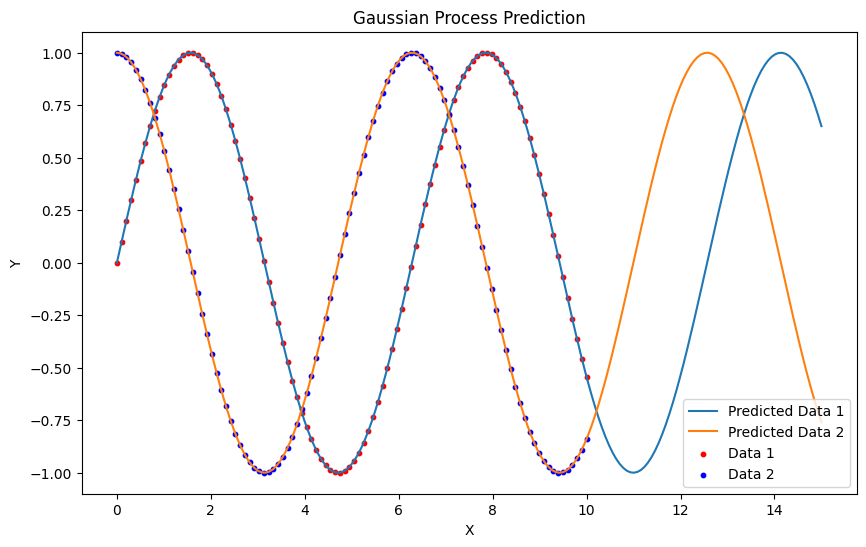

In [41]:
# data preparation
import GPy
import numpy as np
import matplotlib.pyplot as plt

# 두 개의 시계열 데이터 생성
size = 100
t = np.linspace(0, 10, size)
data1 = np.sin(t)
data2 = np.cos(t)

# 데이터 결합
X = np.vstack((data1, data2)).T

# 다변량 가우시안 프로세스 모델 정의
kernel = GPy.kern.RBF(input_dim=2, ARD=True)  # RBF(Radial Basis Function) 커널 사용
m = GPy.models.GPRegression(X, X, kernel)

# 모델 학습
m.optimize(messages=True)

# 새로운 데이터에 대한 예측
new_t = np.linspace(0, 15, 200)
new_data1 = np.sin(new_t)
new_data2 = np.cos(new_t)
X_new = np.vstack((new_data1, new_data2)).T
y_pred, y_var = m.predict(X_new)

# 결과 그래프로 표시
plt.figure(figsize=(10, 6))
plt.plot(new_t, y_pred[:, 0], label='Predicted Data 1')
plt.fill_between(new_t, y_pred[:, 0] - np.sqrt(y_var[:, 0]), y_pred[:, 0] + np.sqrt(y_var[:, 0]), alpha=0.3)

plt.plot(new_t, y_pred[:, 1], label='Predicted Data 2')
plt.fill_between(new_t, y_pred[:, 1] - np.sqrt(y_var[:, 0]), y_pred[:, 1] + np.sqrt(y_var[:, 0]), alpha=0.3)

plt.scatter(t, data1, label='Data 1', color='r', s=10)
plt.scatter(t, data2, label='Data 2', color='b', s=10)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Gaussian Process Prediction')
plt.legend()
plt.show()